In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_optimizer import RAdam
from rse import ResidualShuffleExchangeNetwork
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
plt.style.use("seaborn")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class SeqModel(nn.Module):
    def __init__(self, m, n_classes, n_blocks=1):
        super().__init__()
        self.embedding = nn.Embedding(n_classes, m)
        self.rse = ResidualShuffleExchangeNetwork(m, n_blocks=n_blocks)
        self.linear = nn.Linear(m, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.rse(x)
        x = self.linear(x)
        return x


def plot_training_stats(losses, accuracies):
    fig, ax1 = plt.subplots()
    fig.set_facecolor("white")
    ax2 = ax1.twinx()
    ax1.plot(losses, 'r-')
    ax2.plot(accuracies, 'b-')
    ax1.set_title("Training stats")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Loss")
    ax2.set_ylabel("Accuracy")
    plt.show()


def training_loop(model, batch_generator):
    model.to(device)
    optimizer = RAdam(model.parameters(), lr=0.000883883)
    loss_fn = torch.nn.CrossEntropyLoss()
    loss_fn.to(device)
    max_out_length = 64
    batch_size = 8

    t = tqdm(range(50_000), desc="Training. Loss: , Acc: ")

    losses = []
    accuracies = []

    for _ in t:
        optimizer.zero_grad()
        inp, res = batch_generator(max_out_length, batch_size)
        output = model(inp.to(device))
        flat_output = torch.flatten(output, end_dim=1)
        flat_res = torch.flatten(res).to(device)
        loss = loss_fn(flat_output, flat_res)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(flat_output, dim=-1)
        acc = (preds == flat_res).sum() / len(flat_res)
        losses.append(loss.item())
        accuracies.append(acc.item())
        t.set_description(f"Training. Loss: {np.mean(losses[-100:]):.2f}, Acc: {np.mean(accuracies[-100:]): .2%}")
        if np.mean(accuracies[-500:]) > 0.9999:
            break

    plot_training_stats(losses, accuracies)


def plot_test_errplot(max_out_lengths, accuracy_means, accuracy_stds):
    fig, ax = plt.subplots()
    fig.set_facecolor("white")
    ax.errorbar(np.arange(len(max_out_lengths)), accuracy_means, yerr=accuracy_stds, fmt='o-')
    ax.xaxis.set_ticks(np.arange(len(max_out_lengths)))
    ax.xaxis.set_ticklabels(max_out_lengths)
    ax.set_title("Testing generalization to different seq lenghts")
    ax.set_xlabel("Seq length")
    ax.set_ylabel("Accuracy")
    plt.show()


def test_lengths(model, batch_generator):
    model.to(device)
    model.eval()
    max_out_lengths = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
    batch_size = 8
    examples_per_length = 100

    accuracy_means = []
    accuracy_stds = []

    for length in tqdm(max_out_lengths, desc="Testing."):
        accuracies = []
        for _ in range(examples_per_length):
            with torch.no_grad():
                inp, res = batch_generator(length, batch_size)
                output = model(inp.to(device))
                flat_output = torch.flatten(output, end_dim=1)
                flat_res = torch.flatten(res).to(device)
                preds = torch.argmax(flat_output, dim=-1)
                acc = (preds == flat_res).sum() / len(flat_res)
                accuracies.append(acc.item())
        accuracy_means.append(np.mean(accuracies))
        accuracy_stds.append(np.std(accuracies))

    plot_test_errplot(max_out_lengths, accuracy_means, accuracy_stds)

Training. Loss: , Acc:   0%|          | 0/50000 [00:00<?, ?it/s]

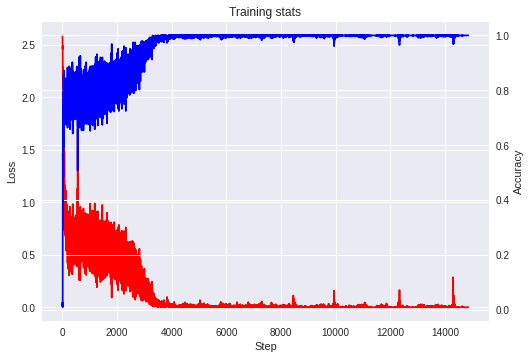

Testing.:   0%|          | 0/11 [00:00<?, ?it/s]

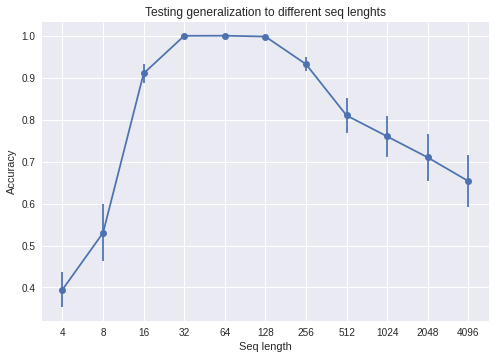

In [4]:
def generate_dup_batch(max_out_length, batch_size, n_classes=13):
    x = [torch.randint(1, n_classes, (np.random.randint(1, max_out_length // 2),)) for _ in
         range(batch_size)]
    xx = [a.repeat(2) for a in x]
    inp = nn.utils.rnn.pad_sequence(x, batch_first=True)
    inp = F.pad(inp, (0, max_out_length - inp.shape[-1]))
    res = nn.utils.rnn.pad_sequence(xx, batch_first=True)
    res = F.pad(res, (0, max_out_length - res.shape[-1]))
    return inp, res

model = SeqModel(192, 13, n_blocks=1)
training_loop(model, generate_dup_batch)
test_lengths(model, generate_dup_batch)

Training. Loss: , Acc:   0%|          | 0/50000 [00:00<?, ?it/s]

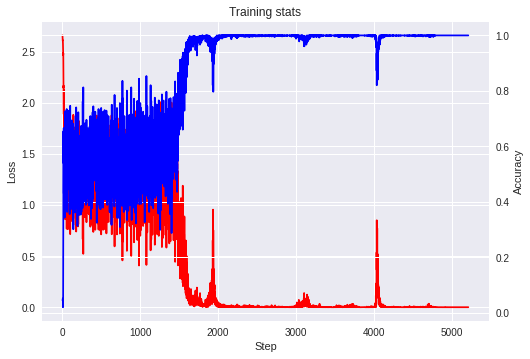

Testing.:   0%|          | 0/11 [00:00<?, ?it/s]

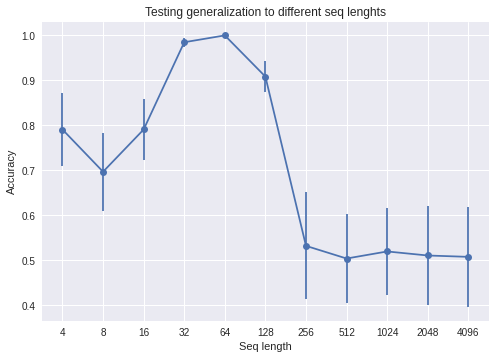

In [5]:
def generate_reverse_batch(max_out_length, batch_size, n_classes=13):
    xs = [torch.randint(1, n_classes, (np.random.randint(1, max_out_length),)) for _ in
         range(batch_size)]
    inp = nn.utils.rnn.pad_sequence(xs, batch_first=True)
    inp = F.pad(inp, (0, max_out_length - inp.shape[-1]))
    res = nn.utils.rnn.pad_sequence([torch.flip(x, (0,)) for x in xs], batch_first=True)
    res = F.pad(res, (0, max_out_length - res.shape[-1]))
    return inp, res

model = SeqModel(192, 13, n_blocks=1)
training_loop(model, generate_reverse_batch)
test_lengths(model, generate_reverse_batch)

Training. Loss: , Acc:   0%|          | 0/50000 [00:00<?, ?it/s]

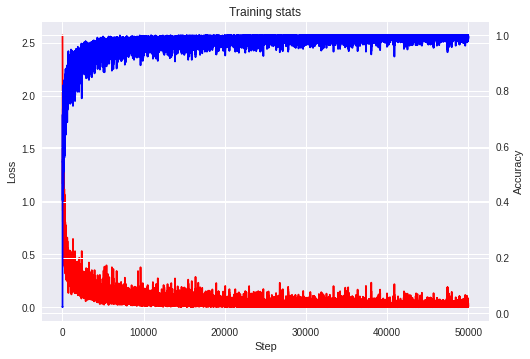

Testing.:   0%|          | 0/11 [00:00<?, ?it/s]

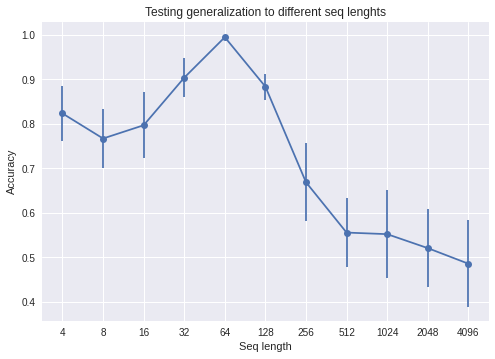

In [6]:
def generate_sorting_batch(max_out_length, batch_size, n_classes=13):
    xs = [torch.randint(1, n_classes, (np.random.randint(1, max_out_length),)) for _ in
         range(batch_size)]
    inp = nn.utils.rnn.pad_sequence(xs, batch_first=True)
    inp = F.pad(inp, (0, max_out_length - inp.shape[-1]))
    res = nn.utils.rnn.pad_sequence([torch.sort(x)[0] for x in xs], batch_first=True)
    res = F.pad(res, (0, max_out_length - res.shape[-1]))
    return inp, res

model = SeqModel(192, 13, n_blocks=1)
training_loop(model, generate_sorting_batch)
test_lengths(model, generate_sorting_batch)